# My First Hackathon
---
#### Реализация модуля бесшовной склейки изображений для подсчета уникальных товаров

In [1]:
!pip install ultralytics

import sys
from abc import ABC, abstractmethod

import numpy as np
import pandas as pd
import cv2
from PIL import Image
from ultralytics import YOLO
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 749.5/749.5 kB 11.8 MB/s eta 0:00:00a 0:00:01


In [2]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

# Runs sift algorithm to find features
def findFeatures(img):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    img = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    cv2.imwrite('sift_keypoints.png', img)
    return keypoints, descriptors

# Matches features given a list of keypoints, descriptors, and images
def matchFeatures(kp1, kp2, desc1, desc2, img1, img2):
    matcher = cv2.BFMatcher(cv2.NORM_L2, True)
    matches = matcher.match(desc1, desc2)
#     matchImg = drawMatches(img1,kp1,img2,kp2,matches)
#     cv2.imwrite('Matches.png', matchImg)
    return matches

In [3]:
# fig, axes = plt.subplots(len(impairs), 1, figsize=(10,40))
# axes = axes.flatten()


def stitch_images(img1name, img2name, save_path):
    estimation_thresh = 0.7

    img1 = cv2.imread(img1name, 0)
    img2 = cv2.imread(img2name, 0)

    img1_color = cv2.imread(img1name)
    img2_color = cv2.imread(img2name)
    
    im1_h, im1_w = img1.shape[:2]
    im2_h, im2_w = img2.shape[:2]
    tgt_size = 400
    max_dim_val = max(im1_h, im1_w, im2_h, im2_w)
    rescale = tgt_size / max_dim_val
    
    
    img1 = cv2.resize(img1, (int(im1_w * rescale), int(im1_h * rescale)))
    img1_color = cv2.resize(img1_color, (int(im1_w * rescale), int(im1_h * rescale)))
    img2 = cv2.resize(img2, (int(im2_w * rescale), int(im2_h * rescale)))
    img2_color = cv2.resize(img2_color, (int(im2_w * rescale), int(im2_h * rescale)))
    
    #find features and keypoints
    correspondenceList = []
    if img1 is not None and img2 is not None:
        
        print("Finding features")
        kp1, desc1 = findFeatures(img1)
        kp2, desc2 = findFeatures(img2)
        keypoints = [kp1,kp2]
        matches = matchFeatures(kp1, kp2, desc1, desc2, img1, img2)
        
        print("Keypoints matched")
        for match in matches:
            (x1, y1) = keypoints[0][match.queryIdx].pt
            (x2, y2) = keypoints[1][match.trainIdx].pt
            correspondenceList.append([x2, y2, x1, y1])

        corrs = np.matrix(correspondenceList)
        finalH, mask = cv2.findHomography(corrs[:,:2], corrs[:,2:], cv2.RANSAC, 15.0)
    
        print(finalH)

        offset = 0
        
        
        h1,w1 = img1.shape[:2]
        h2,w2 = img2.shape[:2]
        pts1 = np.array(([[0,0],[0,h1],[w1,h1],[w1,0]]),dtype=np.float32).reshape(-1,1,2)
        pts2 = np.array(([[0,0],[0,h2],[w2,h2],[w2,0]]),dtype=np.float32).reshape(-1,1,2)
        pts2_ = cv2.perspectiveTransform(pts2, finalH)
        pts = np.concatenate((pts1, pts2_), axis=0)
        [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
        [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
        t = [-xmin,-ymin]
        Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate

        trH = cv2.warpPerspective(img2, Ht.dot(finalH), (xmax-xmin, ymax-ymin))


        finalH[0,2] += offset
        finalH[1,2] += offset
        
#         finalH[2,0] 
#         finalH[2,1] *= 
        
        final_shape = (2 * img1.shape[1] + img2.shape[1], 2 * img1.shape[0] + img2.shape[0])
        print("warping")
        #dst = cv2.warpPerspective(src=img2_color,M=finalH,dsize=final_shape) #wraped image
        dst = cv2.warpPerspective(img2_color, Ht.dot(finalH), (xmax-xmin, ymax-ymin))
        plt.imshow(dst)
        dst[t[1]:h1+t[1],t[0]:w1+t[0]] = img1_color
        #dst[offset:offset+img1.shape[0],offset:offset+img1.shape[1]] = img1_color #stitched image
        
        
        mask = dst.sum(axis=-1) >0
        dst = dst[np.ix_(mask.any(1),mask.any(0))]
        
        cv2.imwrite(save_path, dst)
        return dst

### Exapmle 1 (Vertical matching)

In [4]:
top_img_path = '/kaggle/input/my-first-hackathon-shelf-matching/my-first-hackathon-data/1/top_part.jpeg'
bottom_img_path = '/kaggle/input/my-first-hackathon-shelf-matching/my-first-hackathon-data/1/bottom_part.jpeg'

Finding features
Keypoints matched
[[    0.90538    -0.14454      25.921]
 [   0.048272      0.7311      114.19]
 [ 0.00016267 -0.00070541           1]]
warping
CPU times: user 418 ms, sys: 22.8 ms, total: 441 ms
Wall time: 447 ms


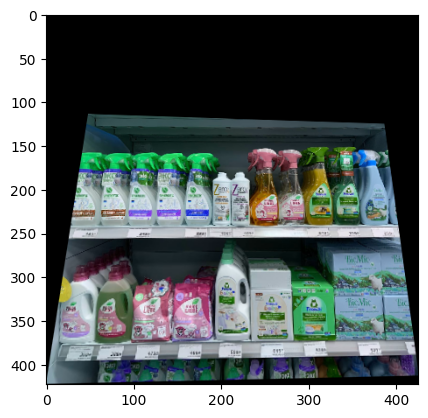

In [11]:
%%time

topdown_img = stitch_images(top_img_path, bottom_img_path, "/kaggle/working/topdown_mymerge.jpg")

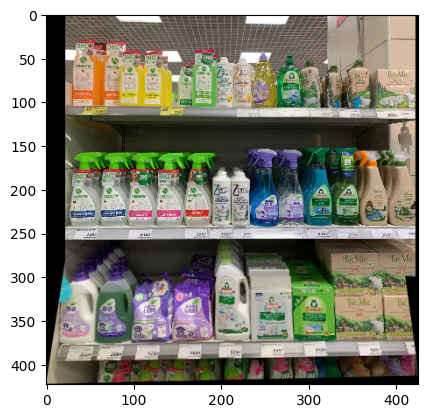

In [6]:
plt.imshow(cv2.cvtColor(topdown_img, cv2.COLOR_BGR2RGB))

In [7]:
top_img = cv2.imread(top_img_path)
bottom_img = cv2.imread(bottom_img_path)

<Figure size 640x480 with 0 Axes>

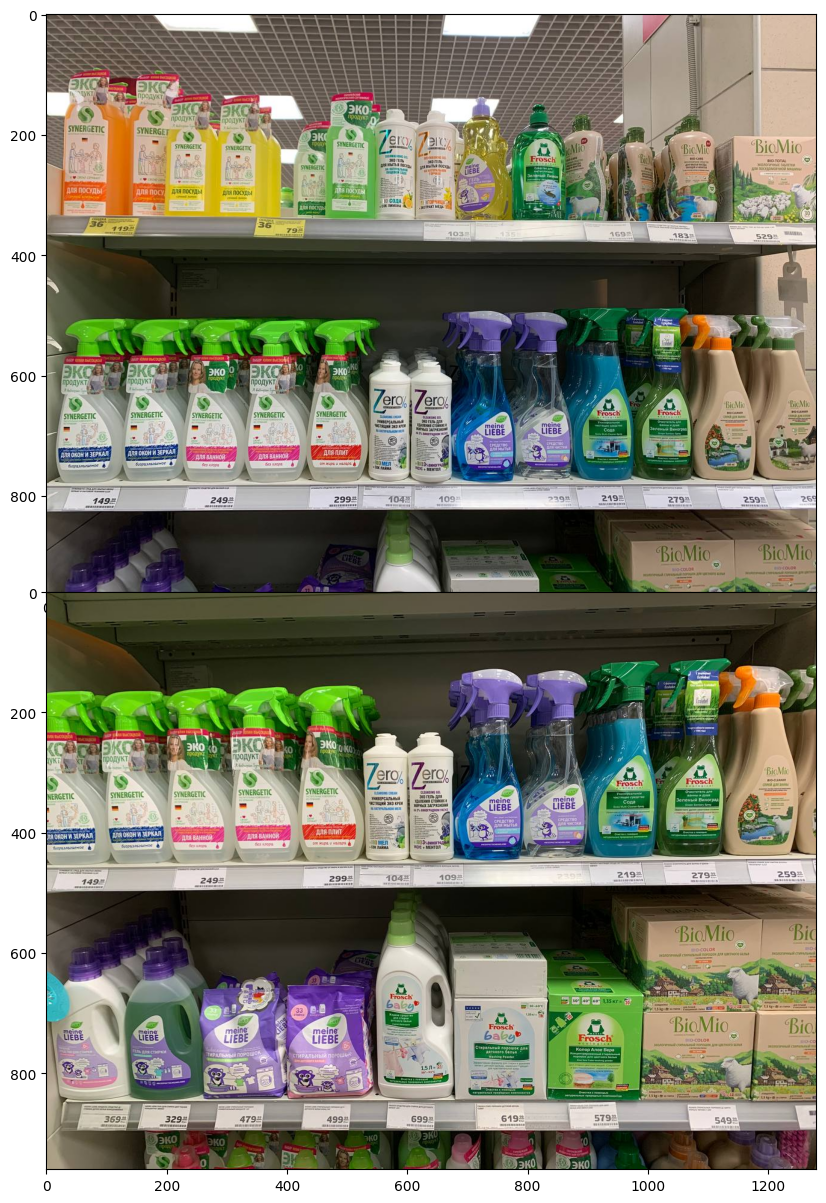

In [8]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,1, figsize=(15, 15))
plt.subplots_adjust(wspace=0, hspace=0)
axarr[0].imshow(cv2.cvtColor(top_img, cv2.COLOR_BGR2RGB));
axarr[1].imshow(cv2.cvtColor(bottom_img, cv2.COLOR_BGR2RGB));

### Example 2 (Horizontal matching)

In [9]:
left_img_path = '/kaggle/input/my-first-hackathon-shelf-matching/my-first-hackathon-data/4/left_part.jpeg'
middle_img_path = '/kaggle/input/my-first-hackathon-shelf-matching/my-first-hackathon-data/4/middle_part.jpeg'

In [10]:
left_img = cv2.imread(left_img_path)
middle_img = cv2.imread(middle_img_path)
#right_img = cv2.imread(right_img_path)

Finding features
Keypoints matched
[[   -0.49429    -0.76024      389.89]
 [   -0.02393     0.60078      33.072]
 [-0.00027045 -0.00094834           1]]
warping


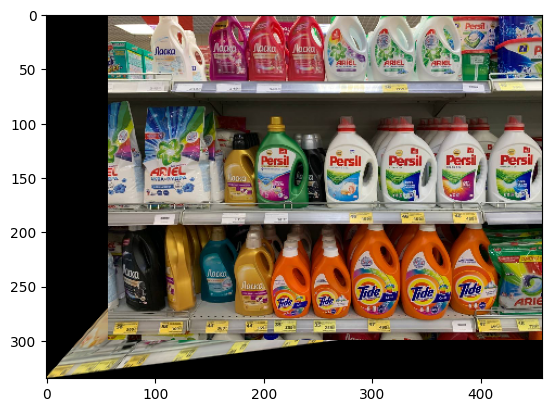

In [133]:
left_img_path = '/kaggle/input/my-first-hackathon-shelf-matching/my-first-hackathon-data/2/left_part.jpeg'
middle_img_path = '/kaggle/input/my-first-hackathon-shelf-matching/my-first-hackathon-data/2/right_part.jpeg'

left_img = cv2.imread(left_img_path)
middle_img = cv2.imread(middle_img_path)


leftmid_path = "/kaggle/working/leftmid.jpg"
leftmid = stitch_images(left_img_path, middle_img_path, leftmid_path)
plt.imshow(cv2.cvtColor(leftmid, cv2.COLOR_BGR2RGB))

<Figure size 640x480 with 0 Axes>

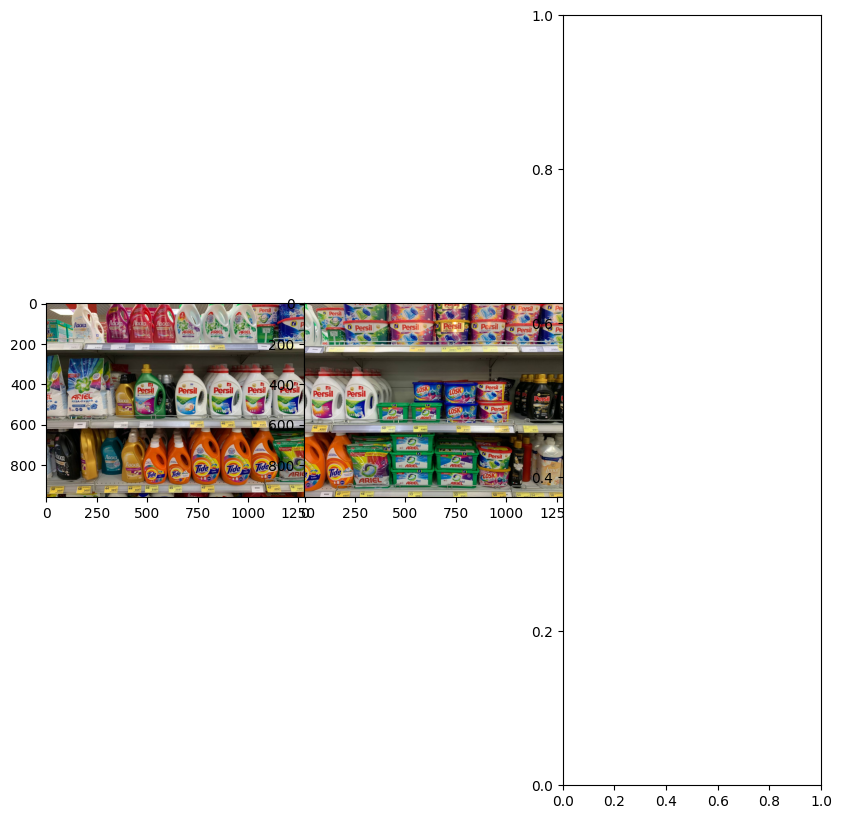

In [135]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3, figsize=(10, 10))
plt.subplots_adjust(wspace=0, hspace=0)
axarr[0].imshow(cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB));
axarr[1].imshow(cv2.cvtColor(middle_img, cv2.COLOR_BGR2RGB));
# axarr[2].imshow(cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB));

Finding features
Keypoints matched
[[   -0.49429    -0.76024      389.89]
 [   -0.02393     0.60078      33.072]
 [-0.00027045 -0.00094834           1]]
warping


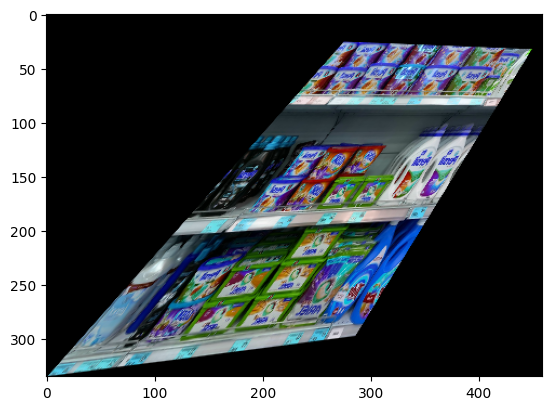

In [136]:
leftmid_path = "/kaggle/working/leftmid.jpg"
leftmid = stitch_images(left_img_path, middle_img_path, leftmid_path)

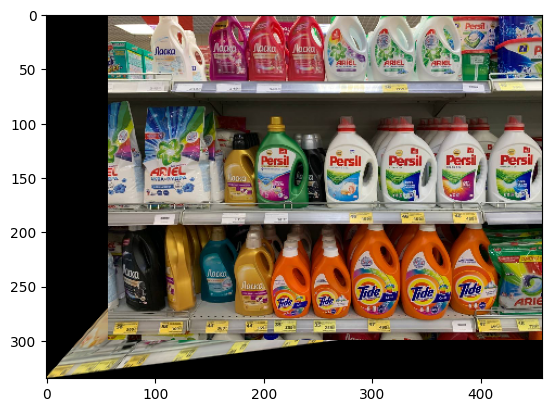

In [137]:
plt.imshow(cv2.cvtColor(leftmid, cv2.COLOR_BGR2RGB))

### Default matching

In [138]:
images = [Image.open(x) for x in [left_img_path, middle_img_path, right_img_path]]
widths, heights = zip(*(i.size for i in images))

total_width = sum(widths)
max_height = max(heights)

new_im = Image.new('RGB', (total_width, max_height))=

x_offset = 0
for im in images:
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]

new_im.save('test_merged.jpg')

SyntaxError: cannot assign to function call (3279714185.py, line 7)

In [ ]:
merged_img = cv2.imread('/kaggle/working/test_merged.jpg')
plt.imshow(cv2.cvtColor(merged_img, cv2.COLOR_BGR2RGB))

### Testing

In [141]:
class Detector(ABC):
    @abstractmethod
    def predict(self, image: np.ndarray):
        pass

class YOLOv8(Detector):
    def __init__(self, detector_model_path):
        self.detector_model_path = detector_model_path
        self.model = YOLO(self.detector_model_path)
    
    def predict(self, image):
        result = self.model.predict(image, save=True, imgsz=1280, conf=0.4)
        return result

In [142]:
yolo_model = YOLOv8(detector_model_path='/kaggle/input/my-first-hackathon-shelf-matching/my-first-hackathon-data/model.pt')

In [149]:
result = yolo_model.predict(topdown_img)


0: 1280x1280 12 products, 1317.4ms
Speed: 12.8ms preprocess, 1317.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)
Results saved to runs/detect/predict2
